In [1]:
import * as pl from "npm:nodejs-polars@0.18.0";
import * as Plot from "npm:@observablehq/plot";
import { document } from "jsr:@manzt/jupyter-helper";

import { computePageRank } from "./src/Graph/Controllers.ts"

In [2]:
const USER_FOLLOW_LIMIT = 100;

const src_data = "data/follows/farcasterdata-*.csv";

const lazyData = pl.scanCSV(src_data, { hasHeader: true });

In [3]:
const degrees = lazyData.groupBy("target_fid")
  .agg(pl.count("target_fid").alias("in_deg"))
  .filter(pl.col("in_deg").gtEq(USER_FOLLOW_LIMIT));

// Adding filtering to remove users without at least 100 follows
const filtered = lazyData.join(degrees, { leftOn: "fid", rightOn: "target_fid", how: "inner" });

const current_network = filtered
  .groupBy(["fid", "target_fid"])
  .agg(
    pl.col("type").sum().alias("type_sum"),
  )

// Added just in case users follow then unfollow in the data.
const cleaned_network = current_network
  .withColumns([
    pl
      .when(pl.col("type_sum").gtEq(1))
      .then(pl.lit(1))
      .otherwise(pl.lit(0))
      .alias("type_sum"),
  ])
  .filter(pl.col("type_sum").eq(1));


In [4]:
const live = await cleaned_network.collect();
console.log(live.height)

4324451


In [5]:
const pr_data = await computePageRank(live);
const plot_records = pr_data.toRecords();

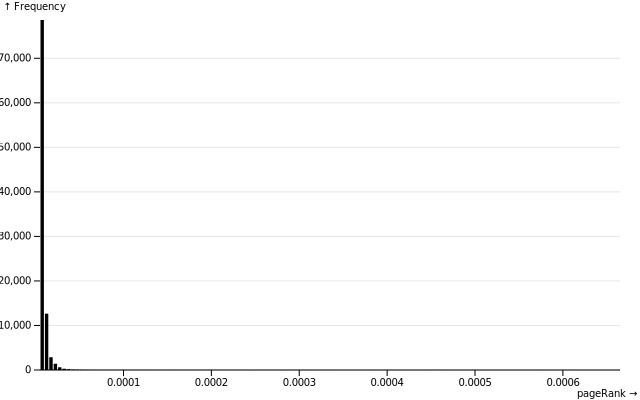

In [6]:
Plot.plot({
  y: {grid: true},
  marks: [
    Plot.rectY(plot_records, Plot.binX({y: "count"}, {x: "pageRank"})),
    Plot.ruleY([0])
  ],
  document
})